In [1]:
%matplotlib inline

# Fantasy Football Data Analysis

I've put together two modules of interest

1. `ffl_data_scraper`: for getting FFL data off of websites, and
2. `ffldata`: for simulating drafts and doing basic draft data analysis

The discussion about the former can be found out on [the github repo](https://github.com/RZachLamberty/ffl_data_scraper). This notebook is dedicated almost exclusively to the former -- all you need to know about the other module is that it scrapes websites such as [espn](http://games.espn.go.com/ffl/tools/projections?&leagueId=209006) and [cbs](http://fantasynews.cbssports.com/fantasyfootball/stats/weeklyprojections/RB/season/avg/ppr) to gather stat predictions and persists that information into a postgres database.

Now, to discuss the latter

## Loading Data

I've abstracted out the postgres integration into a module called `ffldata`

In [2]:
import ffldata

In [3]:
data = ffldata.load_prediction_data()
dataespn = ffldata.load_prediction_data(source='espn')
data.head()

,ffl_source,playername,team,pos,status_type,passing_c,passing_a,passing_yds,passing_td,passing_int,rushing_r,rushing_yds,rushing_td,receiving_rec,receiving_yds,receiving_tot,pts_total,parsed_on
0,espn,Le'Veon Bell,Pit,RB,FA,0,0,0,0,0,247,1063,6,62,502,3,269.5,2015-08-09 16:38:36.773592
1,espn,Eddie Lacy,GB,RB,FA,0,0,0,0,0,304,1348,9,43,306,2,285.3,2015-08-09 16:38:36.786672
2,espn,Jamaal Charles,KC,RB,FA,0,0,0,0,0,245,1128,9,54,463,3,281.2,2015-08-09 16:38:36.794728
3,espn,Adrian Peterson,Min,RB,FA,0,0,0,0,0,266,1245,9,47,398,2,280.3,2015-08-09 16:38:36.803122
4,espn,Marshawn Lynch,Sea,RB,FA,0,0,0,0,0,281,1293,10,33,258,2,273.3,2015-08-09 16:38:36.811514


In [4]:
print data.ffl_source.unique()
print dataespn.ffl_source.unique()

[u'espn' u'cbs']
[u'espn']


## Simulating Draft Data

I created a module named `ffldraft` for helping me make interactive simulations of FFL drafts. 

In [5]:
import ffldraft

I originally created this module to help me track some statistics I was interested in during the course of my league's draft -- specifically, the **replacement value** of a current player. I am defining **replacement value** as the positive difference in point value between a given player and their next best replacement. Alternatively, it can be thought of as the cost of not chosing a player right now.

For example, if player A has a composite predicted score of 220.0 points, and the next best player (player B) has a composite predicted score of 200.0 points, the replacement value of player A would be 20 points. If I don't draft player A, I will lose 20 points net over the course of the year (according to projections).

I've taken the liberty of simulating the first three rounds of the mock draft posted [here](http://espn.go.com/fantasy/football/story/_/id/13188701/12-team-ppr-fantasy-football) -- let's step into the middle of that draft and dig into the current state of the draft a little.

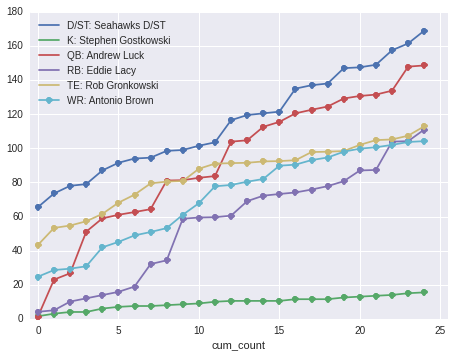

In [10]:
draft = ffldraft.DraftData();
f = draft.show_best_replacement_available();

The plot that was just generated is what I call the "show best available" state of the draft. Each line corresponds to a position, and each point corresponds to the cumulative replacement value (or, cumulative cost) of a player in that position queue.

The y intercept is the current replacement value of the best available player in that positin (e.g. the blue line is Defense and Special Teams; the best team available is the Seatle Seahawks. According to the graph, they are about 65 points better than their replacement).

Big jumps in the graph correspond to big drops in quality of player. There is one big initial drop for both D/ST and TE, but not many beyond that. However, there are several big drops for QB or RB -- those positions are more tiered.

But enough of that -- let's travel through time

In [12]:
# replay draft just loads a csv and updates dataframes accordingly
draft.replay_draft('history.csv')

After three rounds of drafting, how have things changed?

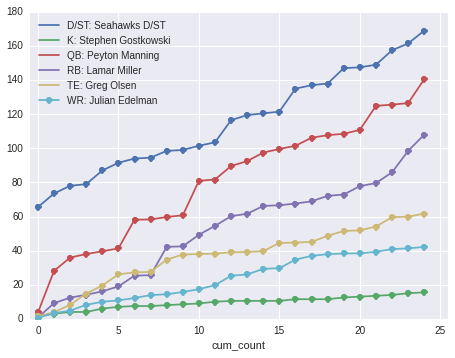

In [13]:
f = draft.show_best_replacement_available()

At this point, it looks like the QB position will be running away with us pretty quickly, and there's still the one remarkable jump for D/ST. I'd be looking to draft those positions if I didn't already have them.

Which speaks to another point -- what about the history of the draft? How do I know what I need, what I have, and how much I have lost so far?

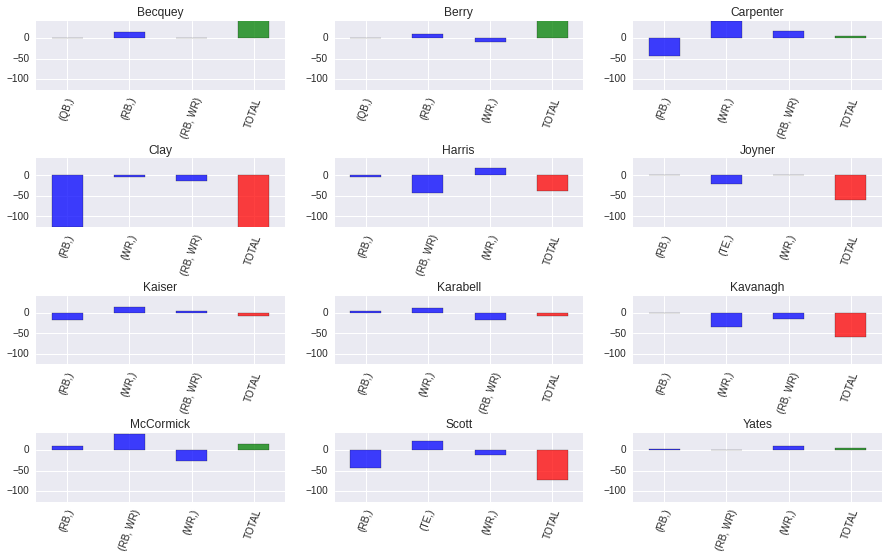

In [15]:
f = draft.state_of_draft();

The above histograms each represent one team and their current starting roster. The bars represent the averaged replacement value (not the difference between player A and player A+1, but rather the difference between player A and the mean drafted player at that position).

Suppose my team has no running back. At this point, I know the net affect of drafting an RB now will be a major net decrease in my team's overall score (I am way behind, that is -- see Clay, above, for an example).

### You're on the clock

Your turn to make a pick (let's say you are `Harris`)

First part of first name?	peyt
First part of last name? 	mann


        playername team
37  Peyton Manning  Den
which index is it? 37


         code
0    Kavanagh
1   McCormick
2   Carpenter
3       Scott
4       Berry
5     Becquey
6      Kaiser
7      Joyner
8        Clay
9    Karabell
10      Yates
11     Harris
which index do you want? 11


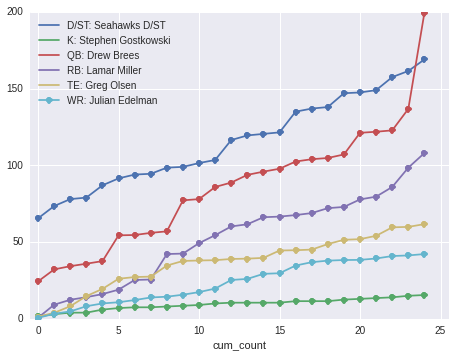

In [17]:
draft.new_draft_interactive()

(for the record, in this position Harris chose Jordan Matthews, WR for the Eagles)

Now it's `Yates's` turn:

First part of first name?	drew
First part of last name? 	brees


    playername team
42  Drew Brees   NO
which index is it? 42


         code
0    Kavanagh
1   McCormick
2   Carpenter
3       Scott
4       Berry
5     Becquey
6      Kaiser
7      Joyner
8        Clay
9    Karabell
10      Yates
11     Harris
which index do you want? 10


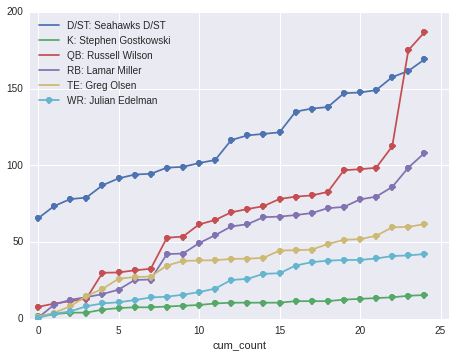

In [18]:
draft.new_draft_interactive()

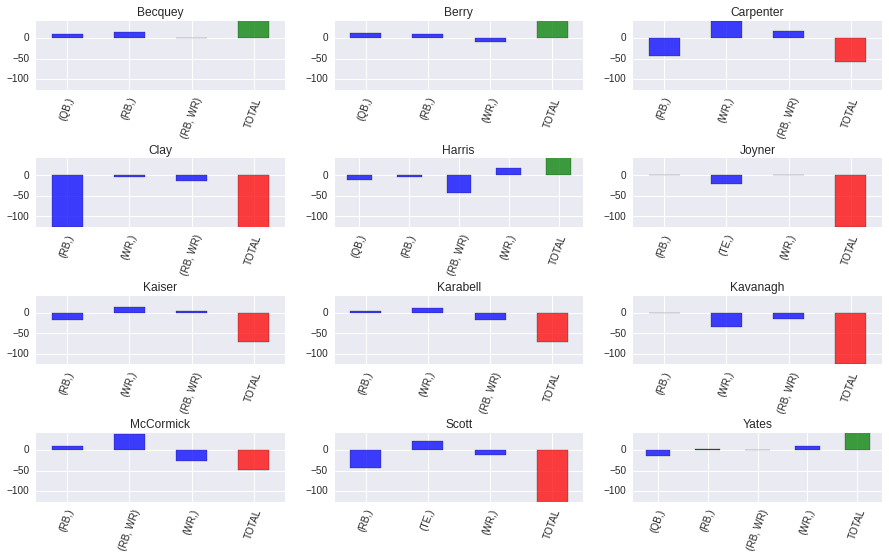

In [20]:
f = draft.state_of_draft();

## Linear Regression

I also created a module `fflmodels` to do some rudimentary analysis of the prediction statistics. My primary motivation here was to have a means of converting stats predictions for one source (e.g. cbs) into total points for comparison with espn.

In [28]:
import fflmodels

Let's start by seeing how well we can reproduce ESPN's scoring system. This is a good test of the inferrence value of this data set, since the actual underlying model (the scoring system) is known in this instance.

In [29]:
df = ffldata.load_prediction_data(source='espn')

In [30]:
scores = fflmodels.lm(df)
scores

,passing_c,passing_a,passing_yds,passing_td,passing_int,rushing_r,rushing_yds,rushing_td,receiving_rec,receiving_yds,receiving_tot,intercept,score
QB,0.427695,-2.768806e-01,3.825159e-02,6.354285e+00,-1.962932e+00,0.395398,0.044671,3.986632,0.000000,0.000000,0.000000,-0.056528,0.999711
RB,0.000000,1.343337e-13,4.529747e-14,1.113640e-16,5.074117e-16,0.099384,0.100751,5.986173,0.429366,0.108020,6.162535,-0.026054,0.999909
TE,0.000000,3.215393e-15,-5.371911e-15,-4.671799e-16,2.043855e-15,0.040098,0.162429,0.001359,0.384423,0.110367,6.128900,-0.019009,0.999968
WR,0.000000,-3.570169e-14,1.501741e-15,1.504143e-15,-1.372997e-17,0.514534,0.065226,0.228013,0.457548,0.105347,6.114362,0.003053,0.999851


The actual scoring system used by ESPN (for this data set) can be found [here](http://games.espn.go.com/ffl/leaguesetup/settings?leagueId=209006):

As you can see, we were able to pretty accurately reproduce the scoring system:

+ passing, rushing, and receiving touchdowns are worth roughly 6 pts
+ passing interceptions are worth approximately -2 pts
+ passing yards are worth approximately 0.04 pts
+ rushing yards are worth approximately 0.1 pts
+ receiving yards are worth approximately 0.1 pts

There are also some annomalies:

+ rushing touchdowns by QBs are wildly underscored
+ number of rushes for QBs are wildly overscored (this and the above may just be the result of QB sneaks on the goal line) 

We also have the `cbs` data set, but the overal point values we would get from that set are using an entirely different scoring system -- that is, unless we use the one we just fit to the ESPN data!

In [32]:
scorecomp = fflmodels.demo_score_comparison(testsource='espn', trialsource='cbs')
scorecomp[['playername', 'team_cbs', 'pos_cbs', 'pts_total_espn', 'pred_pts_total']].head(20)

,playername,team_cbs,pos_cbs,pts_total_espn,pred_pts_total
0,Matt Forte,Chi,RB,303,302.999838
1,Jamaal Charles,KC,RB,294,316.319982
2,Andrew Luck,Ind,QB,393,413.277669
3,Rob Gronkowski,NE,TE,239,211.444366
4,Le'Veon Bell,Pit,RB,281,292.015594
5,Eddie Lacy,GB,RB,263,295.227928
6,Peyton Manning,Den,QB,374,405.418208
7,Aaron Rodgers,GB,QB,366,393.784655
8,Jimmy Graham,Sea,TE,200,183.834534
9,Greg Olsen,Car,TE,200,168.823215


## Furture Work